In [38]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to

import pyro
import pyro.contrib.gp as gp

from scipy.integrate import odeint as odeint_np
import numpy as np
import pandas as pd
import seaborn as sns

from multiprocessing import Pool

pyro.set_rng_seed(2021)
print(pyro.__version__)
np.set_printoptions(4)

%load_ext autoreload
%autoreload 2

1.6.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from BayesOpt import GPBO

In [41]:
%matplotlib notebook

In [3]:
torch.set_num_threads(1)

In [4]:
from numba import njit
from scipy.integrate import solve_ivp
import numpy as np
import os
import scipy.stats
K = 36
J = 10


# %%
@njit
def row_mean_numba(a):
    return np.array([a[i, :].mean() for i in range(a.shape[0])])


@njit
def lorenz96_4para(t, z, F=10, c=10, b=10, h=1, K=36, J=10):
    x = z[:K]
    y = z[K:].reshape(K, J)

    x_k_m_1 = np.roll(x, 1)
    x_k_m_2 = np.roll(x, 2)
    x_k_p_1 = np.roll(x, -1)

    y_flatten = y.ravel()
    y_j_m_1 = np.roll(y_flatten, 1).reshape(y.shape)
    y_j_p_1 = np.roll(y_flatten, -1).reshape(y.shape)
    y_j_p_2 = np.roll(y_flatten, -2).reshape(y.shape)

    y_bar_k = row_mean_numba(y)
    dx = -1 * x_k_m_1 * (x_k_m_2 - x_k_p_1) - x + F - h * c * y_bar_k
    dy = c * (-1 * b * y_j_p_1 * (y_j_p_2 - y_j_m_1) - y + h / J * x.reshape(-1, 1))

    return np.concatenate((dx.ravel(), dy.ravel()))


# %%


F, c, b, h = 10, 10, 10, 1
num_states = K + K * J
args = (F, 8, b, h)
true_args = (F, c, b, h)  # (F, c, b, h, K, J)

# define priors

F_prior = scipy.stats.norm(loc=10, scale=10 ** 0.5)
h_prior = scipy.stats.norm(loc=0, scale=1)
b_prior = scipy.stats.norm(loc=5, scale=10 ** 0.5)

# log-normal to enforce positivity
# s = sigma, scale = exp(mu)
c_prior = scipy.stats.lognorm(s=0.1 ** 0.5, scale=np.e ** 2)

priors = (F_prior, c_prior, b_prior, h_prior)

sample_freq = 10
step_size = 1 / sample_freq


# %%

if os.path.exists("z_long.npz"):
    print("z_long loaded")
    file = np.load("z_long.npz")
    z0 = file["z0"]
    z_long = file["z_long"]
    t = np.arange(0.0, 100, step=step_size)

def summary_stats(z, K=36, J=10, start=0, return_time_avg=True):
    start_idx = start * sample_freq
    X = z[start_idx:, :K]
    Y = z[start_idx:, K:].reshape(-1, K, J)
    X2 = np.square(X)
    Yb = Y.mean(axis=2)
    XYb = X * Yb
    Y2b = np.square(Y).mean(axis=2)

    # X.shape, X2.shape, Y.shape, Yb.shape, XYb.shape, Y2b.shape
    if return_time_avg:
        return (
            X.mean(axis=0),
            Yb.mean(axis=0),
            X2.mean(axis=0),
            XYb.mean(axis=0),
            Y2b.mean(axis=0),
        )
    else:
        return X, Yb, X2, XYb, Y2b


f_long_full = summary_stats(z_long, return_time_avg=False)
covs = [
    np.cov(part, rowvar=False).diagonal().mean() for part in f_long_full
]  # 5 scalars

f_long_avg = [part.mean(axis=0) for part in f_long_full]


def compute_prior_loss(args):
    return -sum((p.logpdf(x) for p, x in zip(priors, args)))


def compute_loss(z):
    stats = summary_stats(z)
    return sum(((stats[i] - f_long_avg[i]) ** 2).sum() / covs[i] for i in range(5)) / 2


def get_loss(args, start=5, T=100, prior=False):
    rand = np.random.randint(200, len(z_long))
    z0 = z_long[rand].copy()

    t_eval = np.arange(0.0, T, step=step_size)
    z = solve_ivp(lorenz96_4para, (0, T), z0, t_eval=t_eval, args=args).y.T
    loss = compute_loss(z[start:]) + (compute_prior_loss(args) if prior else 0)
    return loss

z_long loaded


## Solving Lorenz using BO

In [100]:
def loss_lorenz(args, scaled=True):
    if isinstance(args, torch.Tensor):
        args = args.numpy().squeeze()
        # print(args.shape)
    # Convert to float otherwise the type will not match!
    args = args.copy()
    if scaled:
        args[:3] *= 10
    return torch.tensor([[float(get_loss(args))]])

X1 = np.random.uniform(0, 2, size=(40, 4))
with Pool(20) as p:
    y1 = p.map(loss_lorenz, X1)

iter 0: x=[3.2395e-13 2.0641e-29 2.9791e-09 2.0000e+00], f=85.6752
iter 1: x=[1.5274 2.     2.     2.    ], f=9.5974
iter 2: x=[6.0736e-01 2.0000e+00 7.2976e-07 5.2459e-01], f=18.5232
iter 3: x=[1.0352 1.999  1.9996 1.2465], f=8.0823
iter 4: x=[0.9185 1.4898 0.8535 0.8377], f=3.7258
iter 5: x=[1.1959 1.9993 1.2765 2.    ], f=12.9385
iter 6: x=[0.917 2.    2.    2.   ], f=7.5794
iter 7: x=[8.3919e-01 1.0989e-06 1.0915e+00 1.0921e+00], f=42.7284
iter 8: x=[1.2220e-07 2.0000e+00 4.9765e-08 2.0000e+00], f=62.7986
iter 9: x=[2.0000e+00 2.0000e+00 9.1844e-08 2.0000e+00], f=217.0614
iter 10: x=[0.9168 0.8506 1.1286 2.    ], f=11.0842
iter 11: x=[1.0222 0.7963 2.     2.    ], f=6.3713
iter 12: x=[6.4326e-06 2.1141e-19 2.0000e+00 2.8703e-07], f=69.2169
iter 13: x=[1.1059 2.     1.0919 1.1931], f=2.0976
iter 14: x=[1.1186 0.9421 0.5515 0.5073], f=5.7144
iter 15: x=[0.9429 0.7748 1.9999 1.378 ], f=1.8002
iter 16: x=[1.0188 0.8541 1.1252 1.366 ], f=2.4948
iter 17: x=[1.0333e+00 8.2082e-01 6.0309e-

iter 314: x=[0.9864 0.9416 1.0278 1.0031], f=0.3169
iter 315: x=[1.1779 1.7314 1.1593 1.0333], f=0.4134
iter 316: x=[1.1786 1.7456 1.1459 1.0359], f=0.1527
iter 317: x=[1.1797 1.7518 1.149  1.041 ], f=0.1528
iter 318: x=[1.1811 1.7614 1.1533 1.0498], f=0.2134
iter 319: x=[1.1826 1.7706 1.158  1.0582], f=0.4582
iter 320: x=[1.1797 1.7486 1.1504 1.039 ], f=0.2895
iter 321: x=[1.1797 1.7486 1.1508 1.0393], f=0.4904
iter 322: x=[1.1791 1.7462 1.1472 1.0361], f=0.1869
iter 323: x=[1.1795 1.747  1.1489 1.0371], f=0.3863
iter 324: x=[1.1791 1.7464 1.1478 1.0364], f=0.2159
iter 325: x=[1.1793 1.7469 1.149  1.0372], f=0.2501
iter 326: x=[1.1794 1.7471 1.15   1.0377], f=0.2157
iter 327: x=[1.1795 1.7474 1.1514 1.0386], f=0.3302
iter 328: x=[1.1794 1.7471 1.151  1.0384], f=0.4070
iter 329: x=[1.1792 1.7467 1.1493 1.0374], f=0.6808
iter 330: x=[1.1787 1.7453 1.1437 1.0339], f=0.3461
iter 331: x=[1.1786 1.7449 1.1437 1.034 ], f=0.3090
iter 332: x=[1.1785 1.7448 1.1438 1.0341], f=0.4961
iter 333: x=

iter 472: x=[0.9863 0.9407 1.0307 1.0046], f=0.2701
iter 473: x=[0.9862 0.9405 1.0314 1.005 ], f=0.3005
iter 474: x=[0.9861 0.9403 1.0318 1.0052], f=0.2763
iter 475: x=[0.986  0.9401 1.0326 1.0057], f=0.5773
iter 476: x=[0.9867 0.942  1.0268 1.0023], f=0.2544
iter 477: x=[0.9868 0.9421 1.0265 1.0022], f=0.2448
iter 478: x=[0.9868 0.9422 1.026  1.0019], f=0.3849
iter 479: x=[0.9867 0.9421 1.0264 1.0021], f=0.7619
iter 480: x=[0.9864 0.9412 1.0294 1.0037], f=0.2108
iter 481: x=[0.9863 0.9409 1.0305 1.0043], f=0.3200
iter 482: x=[0.9863 0.9409 1.0305 1.0043], f=0.1248
iter 483: x=[0.986  0.94   1.0332 1.0059], f=0.5629
iter 484: x=[0.9867 0.9422 1.0268 1.0023], f=0.2728
iter 485: x=[0.9868 0.9423 1.0265 1.0021], f=0.3414
iter 486: x=[0.9867 0.9423 1.0266 1.0021], f=0.1728
iter 487: x=[0.9869 0.9426 1.0258 1.0017], f=0.5308
iter 488: x=[0.9866 0.9418 1.0277 1.0028], f=0.2705
iter 489: x=[0.9866 0.9418 1.0277 1.0027], f=0.2489
iter 490: x=[0.9866 0.9418 1.0277 1.0027], f=0.3155
iter 491: x=

<Figure size 864x2160 with 0 Axes>

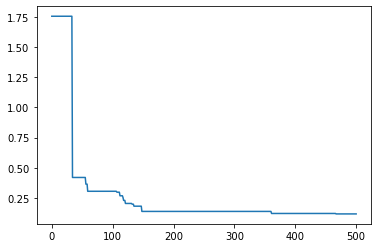

In [101]:
## Fit GP

# gpbo_lorenz = GPBO(torch.tensor(X), torch.tensor(y), loss_lorenz, bound=(0, 2.2), acquistion_fn="EI")
# gpbo_lorenz.train(500)

gpbo_lorenz_lcb1 = GPBO(torch.tensor(X1), torch.tensor(y1), loss_lorenz, bound=(0, 2), acquistion_fn="LCB")
gpbo_lorenz_lcb1.train(500)


In [98]:
%matplotlib inline

In [65]:
len(gpbo_lorenz_lcb.x_hist)

485

In [66]:
paras = pd.DataFrame(gpbo_lorenz_lcb.x_hist, columns=list(i2c))

In [74]:
paras.iloc[:, :3] *= 10

In [71]:
paras[:3] /= 10

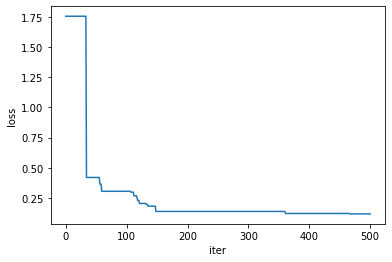

In [102]:
plt.figure()
plt.plot(gpbo_lorenz_lcb1.y_hist)
plt.xlabel("iter")
plt.ylabel("loss")
plt.savefig("results/bo_start40_iter500_loss1.png", dpi=200, facecolor="w")

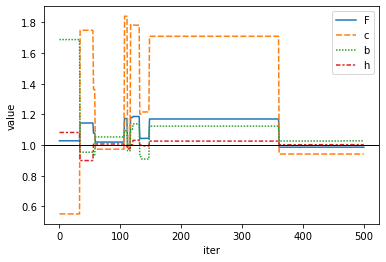

In [103]:
i2c = 'Fcbh'
plt.figure()
sns.lineplot(data=pd.DataFrame(gpbo_lorenz_lcb1.x_hist, columns=list(i2c)))
plt.axhline(y=1.0, color="black", linewidth=1)
plt.xlabel("iter")
plt.ylabel("value")
plt.savefig("results/bo_start40_iter500_1.png", dpi=200, facecolor="w")
plt.show()

In [30]:
gpbo_lorenz_lcb.gpmodel.X[-1:][0].numpy()

array([1.5893e-08, 2.0000e+00, 2.0000e+00, 2.0000e+00])

In [13]:
gpbo_lorenz_lcb.y_min.item()

1.1092678308486938

In [18]:
def loss_lorenz1(arg, scaled=True):
    if isinstance(arg, torch.Tensor):
        arg = arg.detach().item()
        # print(args.shape)
    # Convert to float otherwise the type will not match!
    args = np.array([1, 1, arg, 1])
    
    if scaled:
        args[:3] *= 10
    return torch.tensor([[float(get_loss(args))]])

X1 = np.random.uniform(0, 2, size=(20))
y1 = [loss_lorenz1(arg) for arg in X1]

In [32]:
from BayesOpt import GPBO

x=[0.954], f=0.24464742839336395
x=[2.], f=3.7648651599884033
x=[1.0581], f=0.2284027487039566
x=[0.9658], f=0.37478190660476685
x=[1.06], f=0.2557087540626526
x=[0.9094], f=0.4512554407119751
x=[0.9208], f=0.4921315610408783
x=[1.047], f=0.34271353483200073
x=[1.0443], f=0.23483392596244812
x=[1.0443], f=0.35349127650260925
Final result: 1.0580719709396362, tensor([0.2284])


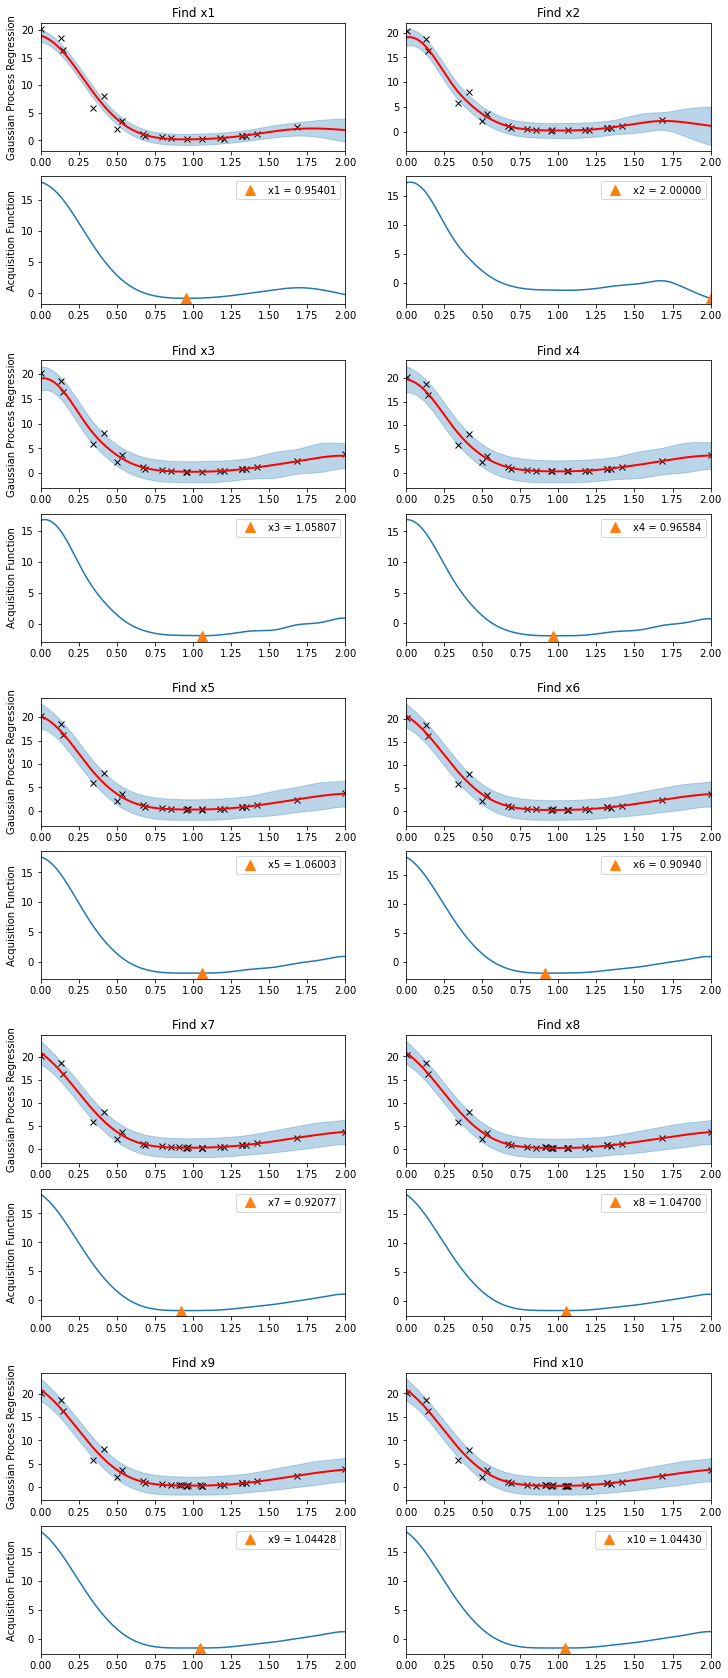

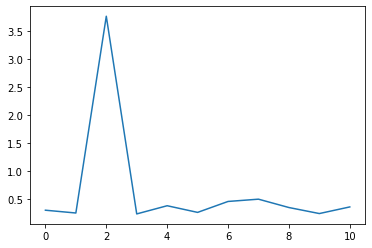

In [52]:
gpbo_lorenz_lcb1 = GPBO(torch.tensor(X1), torch.tensor(y1), loss_lorenz1, bound=(0, 2), acquistion_fn="LCB")
gpbo_lorenz_lcb1.train(10)

In [59]:
def loss_lorenz2(arg, scaled=True):
    if isinstance(arg, torch.Tensor):
        arg = arg.detach().numpy().squeeze()
        # print(args.shape)
    # Convert to float otherwise the type will not match!
    args = np.array([1, 1, arg[0], arg[1]])
    
    if scaled:
        args[:3] *= 10
    return torch.tensor([[float(get_loss(args))]])

X2 = np.random.uniform(0, 2, size=(20, 2))

In [55]:
with Pool(20) as p:
    y2 = p.map(loss_lorenz2, X2)

x=[1.2706e+00 5.6626e-07], f=44.02260208129883
x=[2.6171e-07 3.2343e-01], f=9.471331596374512
x=[0.9633 0.7642], f=1.6707895994186401
x=[6.918e-07 2.000e+00], f=147.0408172607422
x=[0.5181 0.7229], f=1.9929741621017456
x=[0.4453 1.1305], f=4.511117935180664
x=[1.2313 1.9994], f=10.681404113769531
x=[0.6266 1.7118], f=19.63849449157715
x=[8.6951e-05 1.2933e+00], f=80.46931457519531
x=[2.0000e+00 2.6422e-07], f=44.31646728515625
Final result: 0.855697322900911, 1.4957711696624756


<Figure size 864x2160 with 0 Axes>

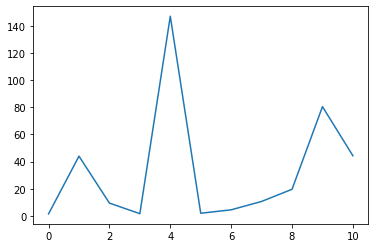

In [60]:
gpbo_lorenz_lcb2 = GPBO(torch.tensor(X2), torch.tensor(y2), loss_lorenz2, bound=(0, 2), acquistion_fn="LCB")
gpbo_lorenz_lcb2.train(10)

(0.0, 2.0)

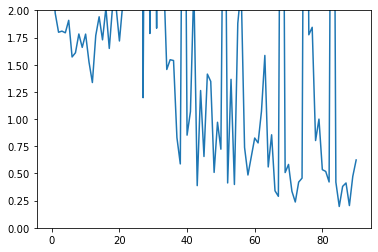

In [65]:
plt.plot(gpbo_lorenz_lcb2.hist[20:])
plt.ylim((0,2))

In [68]:
gpbo_lorenz_lcb2.x_min

tensor([0.9887, 0.9780], dtype=torch.float64)